In [4]:
%load_ext autoreload
%autoreload 2


import os
import sys
import segyio
import warnings
import time

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import shutil
from collections import defaultdict
from copy import deepcopy

sys.path.append('..')
from seismiqb.batchflow import Pipeline, FilesIndex
from seismiqb.batchflow import NumpySampler as NS
from seismiqb.batchflow import B, V, C, L, F, D, P, R, W
from seismiqb.batchflow.models.tf import *
from seismiqb.batchflow.models.tf.layers import *
from seismiqb.batchflow.models.tf.losses import dice_batch
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset, HorizonMetrics, Horizon, IndexedDict

from tqdm import tqdm


%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [5]:
CUBES_PATH = ['/notebooks/data/seismic/CUBE_2/M_cube.hdf5']
HORIZON_DIR = '/PREDICTED_HORIZONS/PREDICTIONS_WITH_HOLES/*'
dsi = FilesIndex(path=CUBES_PATH, no_ext=True)
ds = SeismicCubeset(dsi)
ds = ds.load(horizon_dir=HORIZON_DIR)

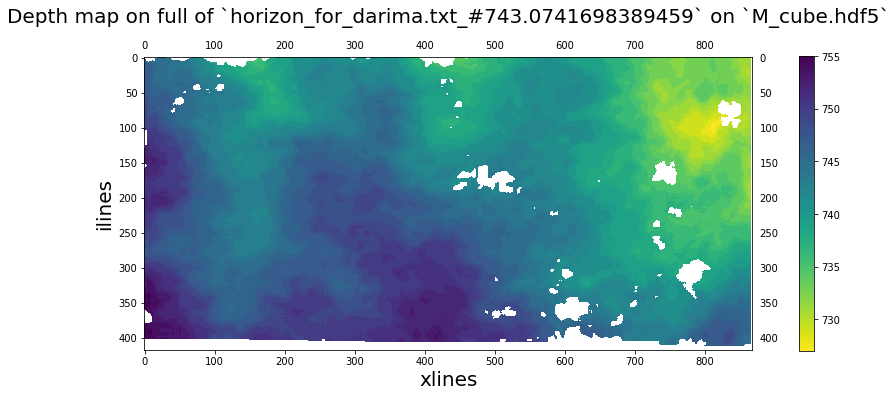

In [6]:
ds.labels[ds.indices[0]][0].show()

In [7]:
ds.predicted_labels = IndexedDict()

ds.predicted_labels[ds.indices[0]] = [Horizon(ds.labels[ds.indices[0]][0].full_matrix.astype(np.int32),
                                              geometry=ds.geometries[ds.indices[0]])]

In [9]:
model_ppl = Pipeline().load_model('static', TFModel, 'extension',
                                  path='/notebooks/seismiqb/experiments/new_expreriments/research_from_14-04-10.54/saved_model/') << ds

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /notebooks/seismiqb/experiments/new_expreriments/research_from_14-04-10.54/saved_model/model-1000


In [10]:
def create_predict_ppl(model_pipeline):
    predict_ppl = (Pipeline()
                   .crop(points=L(D('crops_gen')), shape=L(D('shapes_gen')), passdown=['predicted_labels', 'prior_labels'])
                   .load_cubes(dst='images')
                   .create_masks(dst='cut_masks', width=4, horizons=1, src_labels='predicted_labels')
                   .adaptive_reshape(src=['images', 'cut_masks'], shape=[1, 64, 64])
                   .rotate_axes(src=['images', 'cut_masks'])
                   .scale(mode='normalize', src='images')
                   .import_model('extension', model_pipeline)
                   .init_variable('predicted_horizons', default=list())
                   .predict_model('extension', fetches='predictions',
                                  images=B('images'), cut_masks=B('cut_masks'),
                                  save_to=B('predicted_masks', mode='w'))
                   .apply_transform(lambda x: x[..., 0], src='predicted_masks')
                   .masks_to_horizons(src='predicted_masks', threshold=0.5, minsize=5,
                                      order=L(D('orders_gen')), dst='horizons', skip_merge=True)
                   .update(V('predicted_horizons', mode='e'), B('horizons'))
                  ) << ds
    return predict_ppl

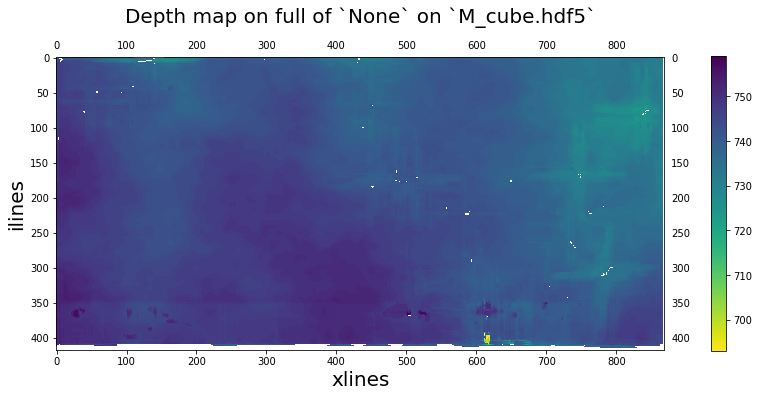

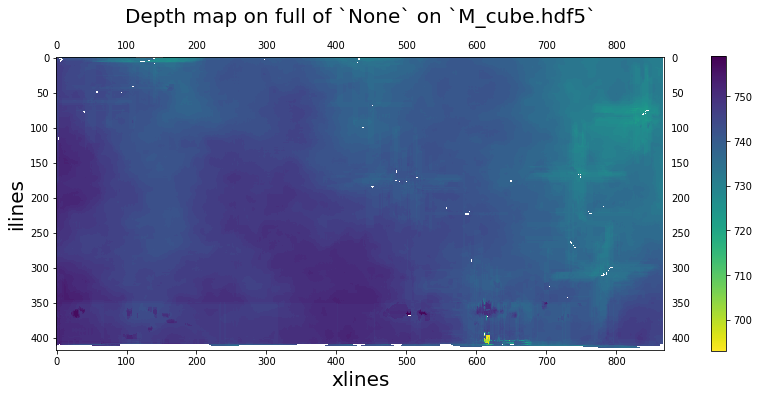

CPU times: user 17.3 s, sys: 3.16 s, total: 20.5 s
Wall time: 18.2 s


In [22]:
%%time
for i in range(2):
    ds.make_expand_grid_v2(ds.indices[0], crop_shape=[1, 64, 64], stride=10,
                                labels_src='predicted_labels', batch_size=200)
    predict_ppl = create_predict_ppl(model_ppl)

    for i in range(ds.crops_iters):
        batch = predict_ppl.next_batch(1, n_epochs=None, profile=True)
        
    merge_candidates = [*predict_ppl.v('predicted_horizons')]
    # , *predict_ppl.v('predict_xline')]
    for hor in merge_candidates:
        merge_code, _ = Horizon.verify_merge(ds.predicted_labels[ds.indices[0]][0], hor,
                                             mean_threshold=16.5,
                                             adjacency=5)
        if merge_code in [2, 3]:
            _ = ds.predicted_labels[ds.indices[0]][0].overlap_merge(hor, inplace=True)
    ds.predicted_labels[ds.indices[0]][0].show()    

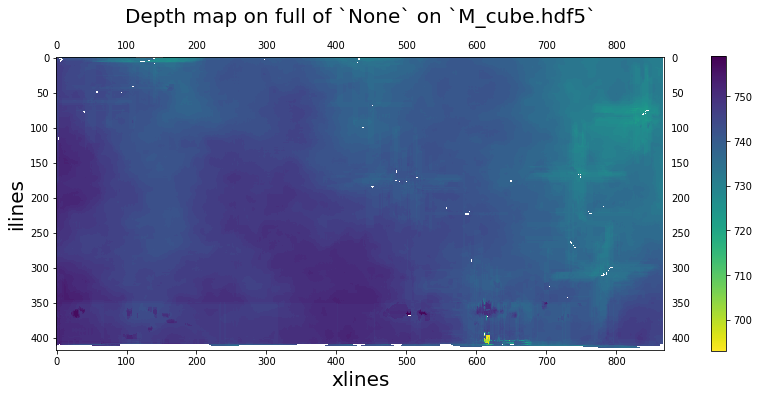

In [23]:
ds.predicted_labels[ds.indices[0]][0].show()


Comparing horizons:       None
                          horizon_for_darima.txt_#743.0741698389459
—————————————————————————————————————————————

Rate in 5ms:                           0.9505
Mean/std of errors:        -0.4694 /   0.9729
Mean/std of abs errors:     0.4903 /   0.9625
Max error/abd error:             6 /        8
—————————————————————————————————————————————

Lengths of horizons:                   356849
                                       341500
—————————————————————————————————————————————
Average heights of horizons:            742.5
                                        743.1
—————————————————————————————————————————————
Coverage of horizons:                   1.012
                                       0.9682
—————————————————————————————————————————————
Solidity of horizons:                  0.9993
                                        0.978
—————————————————————————————————————————————
Number of holes in horizons:               63
                        

(array([[nan, nan, nan, ...,  0.,  0., nan],
        [nan, nan, nan, ...,  0.,  0., nan],
        [ 0.,  1., nan, ...,  0.,  0., nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 {'spatial': True,
  'title': 'Height differences between None and horizon_for_darima.txt_#743.0741698389459 on cube M_cube.hdf5',
  'cmap': 'seismic',
  'zmin': 0,
  'zmax': nan,
  'ignore_value': nan})

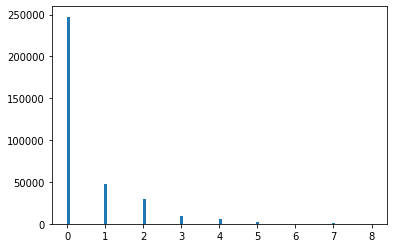

In [19]:
HorizonMetrics([ds.predicted_labels[ds.indices[0]][0], ds.labels[ds.indices[0]]]).compare()

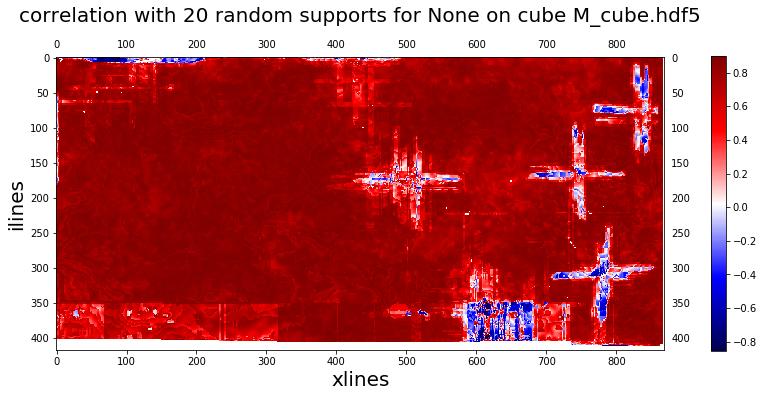

In [21]:
_ = HorizonMetrics([ds.predicted_labels[ds.indices[0]][0]]).evaluate('support_corrs', supports=20, agg='mean', plot=True)